In [87]:
from binance.client import Client
import pandas as pd
import matplotlib.pyplot as plt
import date_to_unix as date
import datetime
import itertools

In [88]:
data2 = pd.read_csv('data\Bitcoin 2019-09-10')

data2['Open Time'] = pd.to_datetime(data2['Open Time'])  # Convert before setting as index
data2.set_index('Open Time', inplace=True, drop=True)
data2

,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate
Open Time,,,,,
2019-09-10 08:00:00,10272.64,10271.93,0.000100,NaN,0.000100
2019-09-10 16:00:00,10176.26,10172.13,0.000100,NaN,0.000200
2019-09-11 00:00:00,10098.19,10094.27,0.000100,NaN,0.000300
2019-09-11 08:00:00,10066.38,10068.41,0.000100,NaN,0.000400
2019-09-11 16:00:00,9990.57,9992.18,0.000100,NaN,0.000500
...,...,...,...,...,...
2024-05-14 00:00:00,62940.09,62912.20,0.000099,62917.600000,0.688804
2024-05-14 08:00:00,62035.39,62002.00,0.000100,62003.151865,0.688904
2024-05-14 16:00:00,61787.60,61750.00,0.000044,61749.900000,0.688948


### No strategy (only hold) 

In [89]:
fees_spot = 0.0001
fees_future = 0.0001
X=10000

In [90]:
import matplotlib.pyplot as plt
# Calculate the funding rate returns
result = X * data2['fundingRate']

# Fraction of BTCUSDT held as perp and spot
fract_perp = (X / data2['Open BTCUSDT_PERP'][0])
fract_spot = (X / data2['Open BTCUSDT_SPOT'][0])


# Final sizes using the last open price
size_final_f = fract_perp * data2['Open BTCUSDT_PERP']
size_final_s = fract_spot * data2['Open BTCUSDT_SPOT']

# PnL Calculation
PandL = ((fract_perp * (-data2['Open BTCUSDT_PERP'] + data2['Open BTCUSDT_PERP'][0])) +
         (fract_spot * (data2['Open BTCUSDT_SPOT'] - data2['Open BTCUSDT_SPOT'][0])))

# Subtract initial fees from the first result
result.iloc[0] -= (X * fees_future + X * fees_spot)

# Compute the cumulative sum
cumulative_sum = result.cumsum()

# Adjust the last value for final fees and add P&L

data2['hold_strat'] = cumulative_sum
data2['hold_strat'] += PandL - (size_final_s * fees_spot + size_final_f * fees_future)
data2['PandL']= PandL
data2

,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,hold_strat,PandL
Open Time,,,,,,,
2019-09-10 08:00:00,10272.64,10271.93,0.000100,NaN,0.000100,-3.000000,0.000000
2019-09-10 16:00:00,10176.26,10172.13,0.000100,NaN,0.000200,1.355045,3.335947
2019-09-11 00:00:00,10098.19,10094.27,0.000100,NaN,0.000300,2.171037,3.136759
2019-09-11 08:00:00,10066.38,10068.41,0.000100,NaN,0.000400,-2.613693,-2.653585
2019-09-11 16:00:00,9990.57,9992.18,0.000100,NaN,0.000500,-1.184910,-2.239603
...,...,...,...,...,...,...,...
2024-05-14 00:00:00,62940.09,62912.20,0.000099,62917.600000,0.688804,6896.704947,22.916683
2024-05-14 08:00:00,62035.39,62002.00,0.000100,62003.151865,0.688904,6903.296898,28.331954
2024-05-14 16:00:00,61787.60,61750.00,0.000044,61749.900000,0.688948,6907.899973,32.447175


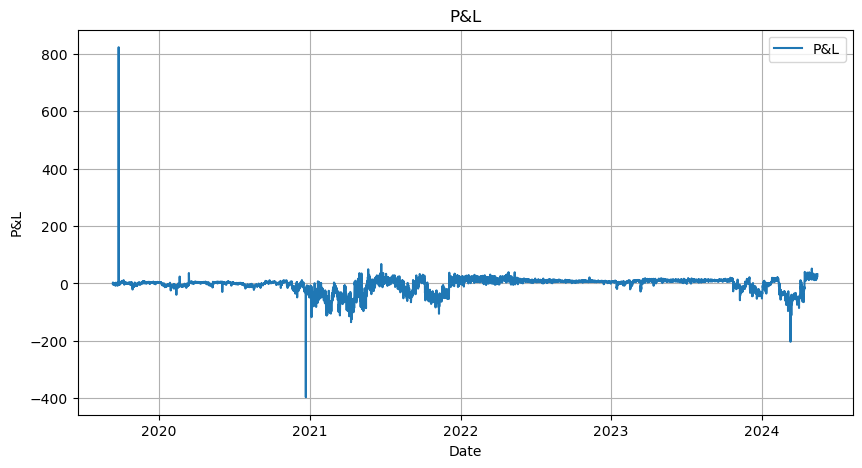

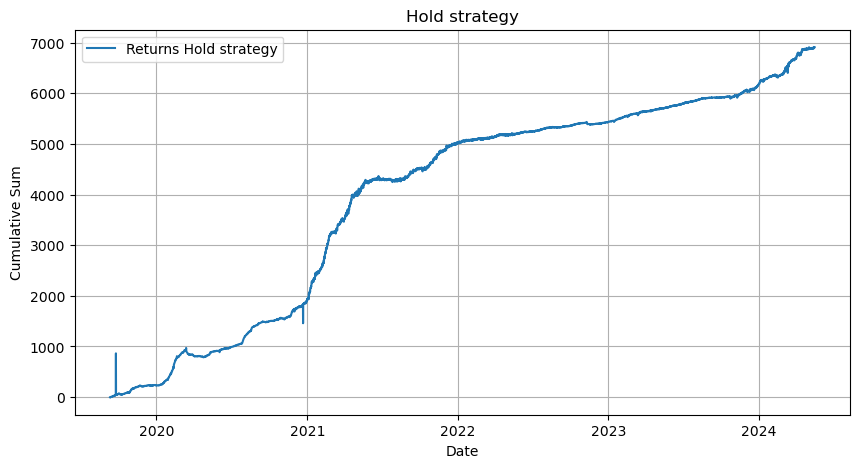

In [91]:

plt.figure(figsize=(10, 5))  # Set the figure size as desired
plt.plot(data2.index, data2['PandL'], label='P&L')
plt.title('P&L')  # Title of the plot
plt.ylabel('P&L')
plt.xlabel('Date')
plt.grid(True)  # Add gridlines for better readability
plt.legend()  # Add a legend if necessary
plt.show()  # Display the plot


plt.figure(figsize=(10, 5))  # Set the figure size as desired
plt.plot(data2.index, data2['hold_strat'], label='Returns Hold strategy')
plt.title('Hold strategy')  # Title of the plot
plt.ylabel('Cumulative Sum')
plt.xlabel('Date')
plt.grid(True)  # Add gridlines for better readability
plt.legend()  # Add a legend if necessary
plt.show()  # Display the plot

In [92]:
print("Without strategies (hold only), the cumulative sum of the funding rate returns would be: ", data2['hold_strat'].iloc[-1].round(4))

Without strategies (hold only), the cumulative sum of the funding rate returns would be:  6908.6963


In [93]:
data2.describe()

,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,hold_strat,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,3979.992205,-3.658253
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2118.472889,26.047711
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-396.399202
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1564.521159,-8.506322
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5048.994958,3.660401
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,5601.320913,9.357027
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,6908.696313,823.137785


## With threshold 

If the funding rate is larger than the fees (sell and buy back perpetual and spot --> 4 times fees), than we close our position and take it back when the funding rate is positive again. 

Condition met at index:  67
Condition met at index:  231
Condition met at index:  555
Condition met at index:  556
Condition met at index:  557
Condition met at index:  559
Condition met at index:  560
Condition met at index:  561
Condition met at index:  562
Condition met at index:  565
Condition met at index:  600
Condition met at index:  605
Condition met at index:  612
Condition met at index:  657
Condition met at index:  1853
Condition met at index:  1969
Condition met at index:  2056
Condition met at index:  2927
Condition met at index:  3473
Condition met at index:  3474
-1.0272640000000002 1.017213 1.009427 1.006841 0.999218


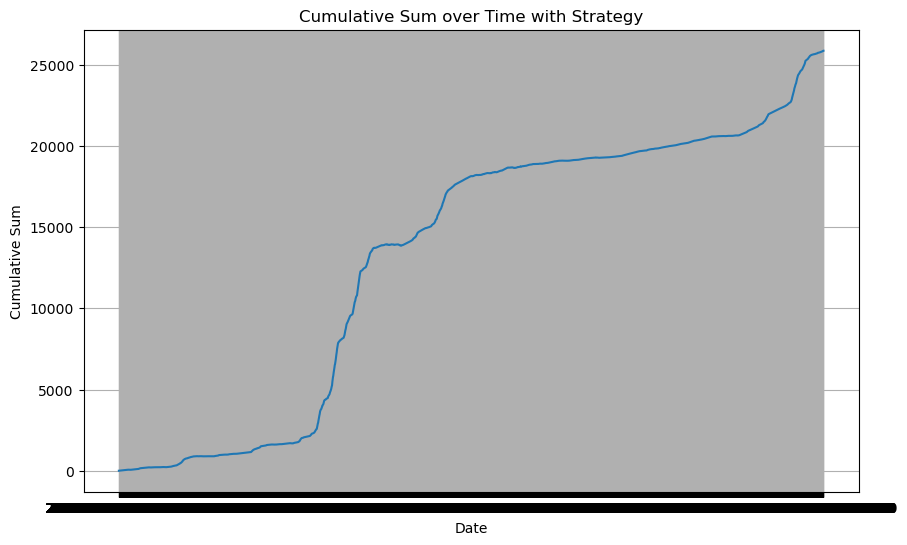

In [43]:
# Get the precedent results 
result = data2['fundingRate'].copy()

# Verify the condition and apply the strategy
for i in range(len(data2)):
    if data2['fundingRate'].iloc[i] < 0 and abs(data2['fundingRate'].iloc[i] * data2['Open BTCUSDT_PERP'].iloc[i]) > (data2['Open BTCUSDT_PERP'].iloc[i] * fees_future + data2['Open BTCUSDT_SPOT'].iloc[i] * fees_spot)*2:
        result.iloc[i] = (data2['Open BTCUSDT_PERP'].iloc[i] * fees_future + data2['Open BTCUSDT_SPOT'].iloc[i] * fees_spot)*2
        print("Condition met at index: ", i)
    else:
        result.iloc[i] = data2['fundingRate'].iloc[i] * data2['Open BTCUSDT_PERP'].iloc[i]


# Substract fees from first result 
result.iloc[0] = result.iloc[0] - (data2['Open BTCUSDT_PERP'][0] * fees_future + data2['Open BTCUSDT_SPOT'][0] * fees_spot)
print(result[0], result[1], result[2], result[3], result[4])
# Comput the cumulative sum 
cumulative_sum = result.cumsum()

# Plot
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(data2.index, cumulative_sum)
plt.xlabel('Date')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum over Time with Strategy')
plt.show()

In [44]:
print("With the strategy, the cumulative sum of the funding rate returns would be: ", cumulative_sum[-1])

With the strategy, the cumulative sum of the funding rate returns would be:  25868.090289903557


## Superpose both graph and compare performance

In [ ]:
# Calculate the funding rate returns 
result1 = data2['fundingRate'] * data2['Open BTCUSDT_PERP']

# Substract fees from first result 
result1[0] = result1[0] - (data2['Open BTCUSDT_PERP'][0] * fees_future + data2['Open BTCUSDT_SPOT'][0] * fees_spot)

# Compute the cumulative sum
cumulative_sum1 = result1.cumsum()

# Get the precedent results 
result2 = data2['fundingRate'].copy()

# Verify the condition and apply the strategy
for i in range(len(data2)):
    if data2['fundingRate'].iloc[i] < 0 and abs(data2['fundingRate'].iloc[i] * data2['Open BTCUSDT_PERP'].iloc[i]) > (data2['Open BTCUSDT_PERP'].iloc[i] * fees_future + data2['Open BTCUSDT_SPOT'].iloc[i] * fees_spot)*2:
        result2.iloc[i] = (data2['Open BTCUSDT_PERP'].iloc[i] * fees_future + data2['Open BTCUSDT_SPOT'].iloc[i] * fees_spot)*2
    else:
        result2.iloc[i] = data2['fundingRate'].iloc[i] * data2['Open BTCUSDT_PERP'].iloc[i]

# Substract fees from first result 
result2.iloc[0] = result2.iloc[0] - (data2['Open BTCUSDT_PERP'][0] * fees_future + data2['Open BTCUSDT_SPOT'][0] * fees_spot)

# Compute the cumulative sum 
cumulative_sum2 = result2.cumsum()

# Plot
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(data2.index, cumulative_sum1, label='Without strategy')
plt.plot(data2.index, cumulative_sum2, label='With strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum over Time')
plt.legend()
plt.show()

### Mise a jour de la strategie 

In [ ]:
# Money originally invested in the strategy
initial_investment = data2['Open BTCUSDT_PERP'][0] + data2['Open BTCUSDT_SPOT'][0]
print(initial_investment)
# Creating a variable to keep track of the updated investment (variation because of funding rate, and fees when closing/entering position)
updated_investment = initial_investment

# Create empty list to store the results
result = []
temp = 0

# Verify the condition and apply the strategy
for i in range(len(data2)):

    # Verify if the funding rate is negative and the absolute value of the funding rate times the open price of the future is greater than the fees of closing and reopening the position
    # In reality, the fees to close the position aren't the same as the fees to open the position 
    # (as the updated invested amount is lower when reopening the position due to closing fees), 
    # but for the sake of simplicity, we will assume they are the same
    if data2['fundingRate'].iloc[i] < 0 and abs(data2['fundingRate'].iloc[i] * (updated_investment/2)) > (((updated_investment/2) * fees_future + (updated_investment/2) * fees_spot)*2):
        
        # Calculate the difference between the open price of the future and the open price of the spot 
        # Not sure it's right --> verify calculations 
        # Not sure because: idk if the difference in future and spot full value is the same as a fraction
        # of spot and future. As the price vary with time, and the money in circulation is not equal to the price
        # we well only be able to purchase a fraction of spot and future, thus idk if the calculations are right 
        difference = (data2['Open BTCUSDT_PERP'].iloc[temp] - data2['Open BTCUSDT_SPOT'].iloc[temp]) - (data2['Open BTCUSDT_PERP'].iloc[i] - data2['Open BTCUSDT_SPOT'].iloc[i])

        # creating temporary variable containing the total money in circulation before closing the position 
        investment_before_closing = updated_investment

        # Quand on reprend la position, on la reprend avec l'investissement total precedent + la difference + l'argent gagné grace au funding rate cumulé 
        cumulative_list = list(itertools.accumulate(result[temp:i]))
        if cumulative_list:  # Check if the list is not empty
            updated_investment += cumulative_list[-1] + difference
        else:
            updated_investment += difference
        
        # Compute the fees (cost of closing and reopening the position)
        fees = ((investment_before_closing/2) * fees_future + (investment_before_closing/2) * fees_spot) + ((updated_investment/2) * fees_future + (updated_investment/2) * fees_spot)
        result.append(-fees) # negative value because we are closing/reopening the position (costs money)

        # Variable to keep the last iteration where the condition was met
        temp = i
    else:
        updated_investment += data2['fundingRate'].iloc[i] * updated_investment
        result.append(data2['fundingRate'].iloc[i] * updated_investment)


# Substract fees from first result 
result[0] = result[0] - (data2['Open BTCUSDT_PERP'][0] * fees_future + data2['Open BTCUSDT_SPOT'][0] * fees_spot)

# Comput the cumulative sum 
cumulative_sum = list(itertools.accumulate(result))
print(cumulative_sum[-1])

# Plot
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(data2.index, cumulative_sum)
plt.xlabel('Date')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum over Time with Strategy')
plt.show()